In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import glob
import seaborn as sns
from numpy import mean, std
from scipy import stats
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.callbacks import History 
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from sklearn import metrics
from sklearn.metrics import classification_report

!pip install autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

     |████████████████████████████████| 204 kB 8.2 MB/s 


# Load Dataset

Load Dataset, concatenate data and count Rows and Columns

In [ ]:
# Download dataset from Github and unzip
!wget 'https://github.com/cargilgar/Smart-Alarm-using-tinyML/raw/main/dataset/dataset-1-1.zip'

!unzip dataset-1-1.zip

In [2]:
# Download RAW dataset from Drive and unzip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IBJjxb8W2vNKA-SyNZIwC5uovWDk9EmA' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1IBJjxb8W2vNKA-SyNZIwC5uovWDk9EmA" -O RAW_dataset.zip && rm -rf /tmp/cookies.txt
!unzip RAW_dataset.zip

--2021-07-28 19:40:09--  https://docs.google.com/uc?export=download&confirm=Kc9L&id=1IBJjxb8W2vNKA-SyNZIwC5uovWDk9EmA
Resolving docs.google.com (docs.google.com)... 142.251.2.138, 142.251.2.100, 142.251.2.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-5g-docs.googleusercontent.com/docs/securesc/6fq59t2s074l8ke902kr0mkkl66mk48b/to1ql71o596ddl8sbk11h0c0q2ofebol/1627501200000/00345810038803350295/03428263168764146944Z/1IBJjxb8W2vNKA-SyNZIwC5uovWDk9EmA?e=download [following]
--2021-07-28 19:40:09--  https://doc-0g-5g-docs.googleusercontent.com/docs/securesc/6fq59t2s074l8ke902kr0mkkl66mk48b/to1ql71o596ddl8sbk11h0c0q2ofebol/1627501200000/00345810038803350295/03428263168764146944Z/1IBJjxb8W2vNKA-SyNZIwC5uovWDk9EmA?e=download
Resolving doc-0g-5g-docs.googleusercontent.com (doc-0g-5g-docs.googleusercontent.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to d

In [7]:
#Create full dataframe with all subject csv's concatenated
path = r'content/output/'
all_files = glob.glob(path + '/*.csv')

li = []
acc_rows = 0

for filename in all_files:
    subject_csv = pd.read_csv(filename, index_col=False)
    acc_rows += len(subject_csv.axes[0])

    li.append(subject_csv)

df = pd.concat(li, axis=0, ignore_index=True)


#Save big dataframe as CSV
# df.to_csv('all_users_df.csv')

#Rows and Columns
total_rows = len(df.axes[0]) #===> Axes of 0 is for a row
total_cols = len(df.axes[1]) #===> Axes of 1 is for a column
print('Number of Rows: ', total_rows)
print('Number of Columns: ', total_cols)

assert total_rows == acc_rows, 'Number of rows does not match'

df

Number of Rows:  1417303
Number of Columns:  6


,Time,X,Y,Z,Heart Rate,Labels
0,-0.009583,-0.400299,0.206558,-0.900787,62.0,-1.0
1,0.010698,-0.402268,0.202652,-0.899857,62.0,-1.0
2,0.030628,-0.401321,0.198257,-0.897873,62.0,-1.0
3,0.050575,-0.400436,0.198273,-0.893494,62.0,-1.0
4,0.070622,-0.400513,0.201706,-0.890091,62.0,-1.0
...,...,...,...,...,...,...
1417298,28439.901214,-0.311295,-0.352463,0.877045,73.0,-1.0
1417299,28439.921193,-0.312805,-0.352463,0.878952,73.0,-1.0
1417300,28439.941228,-0.312790,-0.352951,0.878464,73.0,-1.0
1417301,28439.961231,-0.313705,-0.353943,0.876022,73.0,-1.0


In [ ]:
# df = df.drop('Time', axis=1)

##EDA

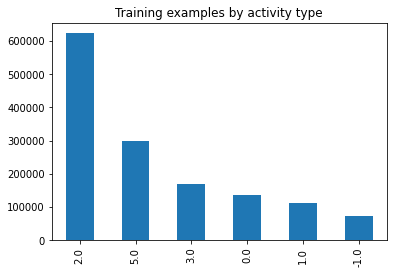

In [8]:
#Labels Distribution
df['Labels'].value_counts().plot(kind='bar',title='Training examples by activity type')

In [ ]:
#BoxPlot for Accelerometer data
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.boxplot(data=df[['X', 'Y', 'Z']], orient='h')
display(ax)

In [ ]:
#BoxPlot for Heart Rate data
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.boxplot(data=df[['Heart Rate']],orient='h')
display(ax)

In [ ]:
'''
df = df.drop(df.index[df.X > 0.2])
df = df.drop(df.index[df.Y > 0.2])
df = df.drop(df.index[df.Z > 0.3])
'''

In [ ]:
sns.pairplot(df[['X', 'Y', 'Z']], kind="scatter", diag_kind= 'kde', height=4)

In [ ]:
#Add interesting Features
df['movement_x'] = df['X'] - df['X'].shift()
df['movement_y'] = df['Y'] - df['Y'].shift()
df['movement_z'] = df['Z'] - df['Z'].shift()
df['modulo'] = (df['X']**2 + df['Y']**2 + df['Z']**2)**0.5
df['modulo_movement'] = (df['movement_x']**2 + df['movement_y']**2 + df['movement_z']**2)**0.5

df

In [9]:
labels = df['Labels']

In [10]:
labels = df['Labels']

df_feature = df.drop('Labels', axis=1).fillna(0)
target = df['Labels']

for steps in range(2):
    print("### AutoFeat with %i feateng_steps" % steps)
    afreg = AutoFeatRegressor(verbose=1, feateng_steps=steps)
    df = afreg.fit_transform(df_feature, target)
    r2 = afreg.score(df_feature, target)
    print("## Final R^2: %.4f" % r2)

### AutoFeat with 0 feateng_steps
[AutoFeat] The 0 step feature engineering process could generate up to 5 features.
[AutoFeat] With 1417303 data points this new feature matrix would use about 0.03 gb of space.
[feateng] Warning: no features generated for max_steps < 1.
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 5 features after 5 feature selection runs
[featsel] 5 features after correlation filtering
[featsel] 5 features after noise filtering
[AutoFeat] Final dataframe with 5 feature columns (0 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
3.4643558202554914
-2.147975 * Y
0.807391 * X
-0.144698 * Z
-0.036284 * Heart Rate
0.000077 * Time
[AutoFeat] Final score: 0.2637
## Final R^2: 0.2637
### AutoFeat with 1 feateng_steps
[AutoFeat] The 1 step feature engineer

# Labels
Initial stages (0-5, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5)

Relabeled stages (0-2, wake = 0, NREM = 1, REM = 2)

In [11]:
# Delete non-labeled Rows
df.dropna(inplace=True)

df['Labels'] = labels
df['Labels'] = df['Labels'].astype(int)

df = df.drop(df.index[(df.Labels < 0) | (df.Labels == 4)])

# Show labels
# Same labels will be reused throughout the program
df['Labels'] = df['Labels'].map({0:0,1:1,2:2,3:3,5:4,}, na_action=None)

df

,Time,X,Y,Z,Heart Rate,Y**3,Labels
63990,1360.411706,-0.272247,-0.330856,0.899170,74.0,-0.036217,0
63991,1360.431738,-0.274185,-0.332321,0.898163,76.0,-0.036701,0
63992,1360.452146,-0.273697,-0.330368,0.898163,76.0,-0.036057,0
63993,1360.471887,-0.273697,-0.328903,0.898163,76.0,-0.035580,0
63994,1360.491741,-0.273178,-0.328430,0.896225,71.0,-0.035427,0
...,...,...,...,...,...,...,...
1406803,28229.901732,-0.322678,-0.331482,0.881638,68.0,-0.036423,0
1406804,28229.921770,-0.323685,-0.331482,0.883072,68.0,-0.036423,0
1406805,28229.941761,-0.322678,-0.332947,0.882126,68.0,-0.036908,0
1406806,28229.961652,-0.323181,-0.331970,0.882599,68.0,-0.036585,0


# Normalize Training Data
Next, we need to normalize our features within our training data. Of course there are various ways on how to normalize. Please keep in mind that you use the same normalization algorithm later when feeding new data into your neural network. Otherwise your preditions will be off. On top of the normalization we will also apply rounding to the three features.

In [ ]:
# Normalize features for training data set (values between 0 and 1)***
# Surpress warning for next 3 operation
'''
pd.options.mode.chained_assignment = None  # default='warn'
df['X'] = df['X'] / df['X'].max()
df['Y'] = df['Y'] / df['Y'].max()
df['Z'] = df['Z'] / df['Z'].max()
df['Heart Rate'] = df['Heart Rate'] / df['Heart Rate'].max()

# Round numbers (4 decimals for accelerometer and 2 for heart rate)
df = df.round({'X': 4, 'Y': 4, 'Z': 4, 'Heart Rate' : 4})

df
'''

# Split Dataset
Train, Validation and Test

Split the data
We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

***ANOTHER SPLITING OPTION WOULD BE TO SEPARATE USERS (Crear nueva columna con nombre usuario?? O manejar cada CSV por separado??)***





In [12]:
column_indices = {name: i for i, name in enumerate(df.columns)}

PERCENTAGE_TRAIN = 0.7
PERCENTAGE_VALIDATION = 0.18

total_rows = df.shape[0]
train_df = df[:int(total_rows*PERCENTAGE_TRAIN)]
val_df = df[int(total_rows*PERCENTAGE_TRAIN):int(total_rows*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN))]
test_df = df[int(total_rows*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN)):]

assert len(train_df) + len(val_df) + len(test_df) == total_rows, 'The split does not match'

# Reshape Data into Segments and Prepare for Keras
The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let’s create another function for this called “create_segments_and_labels”. This function will take in the dataframe and the label names.

In [13]:
def create_segments_and_labels(dataframe):

    labels = dataframe.iloc[:,-1:]
    segments = dataframe.iloc[:,:-1]
    # dataframe.iloc[:,:12]  # from 0 to 12 columns, all the rows

    return segments, labels

In [14]:
# x --> Features
# y --> Labels
   
x_train, y_train = create_segments_and_labels(train_df)
x_val, y_val = create_segments_and_labels(val_df)
x_test, y_test = create_segments_and_labels(test_df)

assert x_train.shape[0] == len(y_train)
assert x_val.shape[0] == len(y_val)
assert x_test.shape[0] == len(y_test)

# Deep Neural Network Model in Keras


In [11]:
# Prepare labels data 
# Needed ONLY for categorical_crossentropy loss function
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

'''
# To review, if the test portion do not comprises the 5 labels, add the needed
# dimensions so that for categorical we still have 5 dimensions.

while y_test.shape[1] < 5:
    y = np.zeros((1, y_test.shape[0]))
    y = np.transpose(y)
    y_test = np.hstack((y_test, y))
'''

'\n# To review, if the test portion do not comprises the 5 labels, add the needed\n# dimensions so that for categorical we still have 5 dimensions.\n\nwhile y_test.shape[1] < 5:\n    y = np.zeros((1, y_test.shape[0]))\n    y = np.transpose(y)\n    y_test = np.hstack((y_test, y))\n'

In [15]:
# define the keras model
num_classes = 5

model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax')) #Last layer corresponds with the number of possible outputs

# compile the keras model
# opt = SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 6,821
Trainable params: 6,821
Non-trainable params: 0
_________________________________________________________________


Train Model

In [ ]:
# fit the keras model on the dataset
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=150, verbose=1)

# Evaluate Model on Test Data

In [11]:
# evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

35660/35660 [==============================] - 57s 2ms/step - loss: 1.1755 - accuracy: 0.6122
Test accuracy 0.6121861338615417
Test loss 1.1754882335662842


In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: ignored

Confusion Matrix

In [13]:
predictions = history.model.predict(x_test)

NameError: ignored

In [ ]:
guess = 0

to_predict = len(y_test)

for index in range(to_predict):
    if np.argmax(predictions[index]) == np.argmax(y_test[index]):
        guess += 1

# np.argmax(predictions[index]), np.argmax(y_test[index])
print("Guessed: {:.2f}%".format(guess/to_predict*100))

Guessed: 27.62%


In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                #xticklabels=LABELS,
                #yticklabels='0','1','2',
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

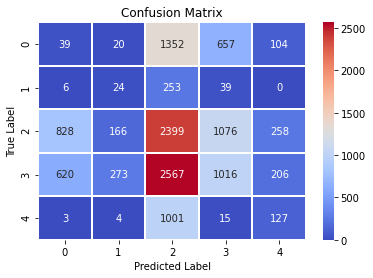

              precision    recall  f1-score   support

           0       0.03      0.02      0.02      2172
           1       0.05      0.07      0.06       322
           2       0.32      0.51      0.39      4727
           3       0.36      0.22      0.27      4682
           4       0.18      0.11      0.14      1150

    accuracy                           0.28     13053
   macro avg       0.19      0.19      0.18     13053
weighted avg       0.27      0.28      0.26     13053



In [ ]:
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

# Predictions

In [ ]:
# test the trained model with the full x_test
predictions = model.predict(x_test)

In [ ]:
predictions[0], y_test[0]

(array([0.02846027, 0.89990205, 0.07163768], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [ ]:
predictions[500], y_test[500]

(array([0.05969261, 0.7548642 , 0.18544324], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [ ]:
predictions[800], y_test[800]

(array([0.06639516, 0.5557858 , 0.37781912], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [ ]:
predictions[1200], y_test[1200]

(array([0.04926674, 0.74609387, 0.20463938], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [ ]:
predictions[2000], y_test[2000] # bad prediction

NameError: ignored

In [ ]:
predictions[2400], y_test[2400]

(array([0.05789682, 0.83688635, 0.10521688], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [ ]:
for i in range(2000):
    predictions[i]

NameError: ignored